## Image Classification Exploiting Sparsity

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
np.random.seed(42)

### Model training

In [2]:
# Fetching dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X = np.concatenate((X_train, X_test))
labels = np.concatenate((y_train, y_test))
X = X.reshape(X.shape[0],-1) / 255
labels = labels.reshape(labels.shape[0],-1)

N = X.shape[1] # 28x28 = 784
num_labels = len(np.unique(labels))

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Neural network used for digit classification
def ClassificationNN(input_dim, num_labels, hidden_layer_size, dropout):

    model = Sequential()
    model.add(Dense(hidden_layer_size, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layer_size))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))

    return model

In [5]:
# Dataset splitting - 70% train, 10% val, 20% test
X_train_val, X_test, labels_train_val, labels_test = train_test_split(X,
                                                                      labels,
                                                                      test_size=0.2,
                                                                      random_state=42,
                                                                      stratify=labels)

X_train, X_val, labels_train, labels_val = train_test_split(X_train_val,
                                                            labels_train_val,
                                                            test_size=1/8,
                                                            random_state=42,
                                                            stratify=labels_train_val)

# One-hot encoding
labels_train_cat = to_categorical(labels_train)
labels_val_cat = to_categorical(labels_val)
labels_test_cat = to_categorical(labels_test)
labels_train_cat.shape

(49000, 10)

In [ ]:
# Build model
batch_size = 128
num_epochs = 40
model = ClassificationNN(input_dim=N, num_labels=num_labels, hidden_layer_size=256, dropout=0.45)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

In [ ]:
# Train model
# Instead of a fixed number of epochs, perform early stopping
history = model.fit(X_train,
                    labels_train_cat,
                    validation_data = (X_val,labels_val_cat),
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/40
383/383 [==============================] - 3s 5ms/step - loss: 0.4562 - accuracy: 0.8585 - val_loss: 0.1821 - val_accuracy: 0.9470
Epoch 2/40
383/383 [==============================] - 2s 5ms/step - loss: 0.2056 - accuracy: 0.9383 - val_loss: 0.1278 - val_accuracy: 0.9640
Epoch 3/40
383/383 [==============================] - 2s 5ms/step - loss: 0.1602 - accuracy: 0.9513 - val_loss: 0.1115 - val_accuracy: 0.9666
Epoch 4/40
383/383 [==============================] - 2s 6ms/step - loss: 0.1352 - accuracy: 0.9593 - val_loss: 0.0932 - val_accuracy: 0.9719
Epoch 5/40
383/383 [==============================] - 3s 7ms/step - loss: 0.1194 - accuracy: 0.9627 - val_loss: 0.0950 - val_accuracy: 0.9717
Epoch 6/40
383/383 [==============================] - 3s 7ms/step - loss: 0.1058 - accuracy: 0.9677 - val_loss: 0.0858 - val_accuracy: 0.9749
Epoch 7/40
383/383 [==============================] - 2s 6ms/step - loss: 0.0960 - accuracy: 0.9706 - val_loss: 0.0820 - val_accuracy: 0.9756
Epoch 

In [ ]:
# Validate performance on original images
val_X_loss, val_X_acc = model.evaluate(X_val, labels_val_cat, verbose=0)
print(f"Val loss on original images = {val_X_loss:.3f}, Val acc on original images = {100*val_X_acc:.2f}%")

Val loss on original images = 0.069, Val acc on original images = 97.80%


Try hidden layer sizes different from 256:

In [ ]:
for hidden_layer_size in [128, 512, 1024]:
    print(f"For hidden_layer_size = {hidden_layer_size}:")
    model2 = ClassificationNN(input_dim=N, num_labels=num_labels, hidden_layer_size=hidden_layer_size, dropout=0.45)

    model2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model2.fit(X_train,
              labels_train_cat,
              validation_data = (X_val,labels_val_cat),
              epochs=num_epochs,
              batch_size=batch_size,
              shuffle=True,
              verbose=0,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

    val_X_loss2, val_X_acc2 = model2.evaluate(X_val, labels_val_cat, verbose=0)
    print(f"Val loss on original images = {val_X_loss2:.3f}, Val acc on original images = {100*val_X_acc2:.2f}%")

For hidden_layer_size = 128:
Val loss on original images = 0.088, Val acc on original images = 97.33%
For hidden_layer_size = 512:
Val loss on original images = 0.070, Val acc on original images = 98.00%
For hidden_layer_size = 1024:
Val loss on original images = 0.080, Val acc on original images = 97.66%


They are all great, but using hidden_layer_size = 256 leads to the lowest val_loss. So we keep 256 as the best value.

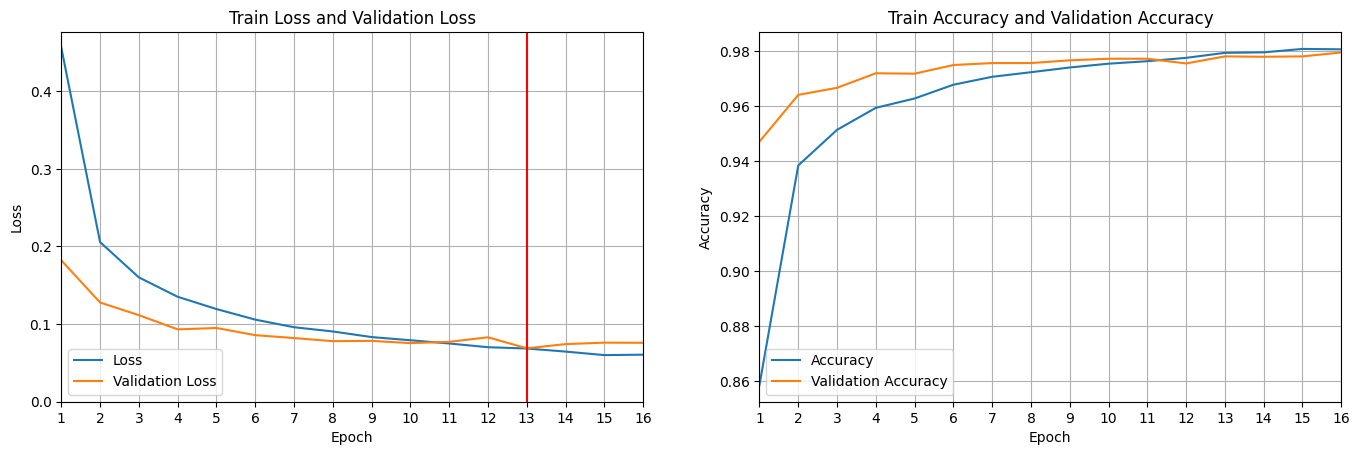

In [ ]:
# Plotting loss, val loss, acc, val acc
plt.figure()
epochs_needed = len(history.history['val_loss'])
min_val_loss_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

plt.subplots_adjust(left=0, right=2)
plt.subplot(1,2,1)
epoch_axis = np.arange(1,epochs_needed+1)
plt.plot(epoch_axis, history.history['loss'])
plt.plot(epoch_axis, history.history['val_loss'])
plt.xticks(epoch_axis)
plt.xlim([1,epochs_needed])
plt.ylim([0, None])
plt.axvline(min_val_loss_epoch+1, color='r')
plt.title("Train Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend(['Loss', 'Validation Loss'])

plt.subplot(1,2,2)
plt.plot(epoch_axis, history.history['accuracy'])
plt.plot(epoch_axis, history.history['val_accuracy'])
plt.xlim([1,epochs_needed])
plt.xticks(epoch_axis)
# plt.ylim([0, None])
plt.title("Train Accuracy and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend(['Accuracy', 'Validation Accuracy'])

The smallest validation loss is obtained at epoch 13.

### Exploring the effect of m (compressed vector dimension) and alpha (regularization parameter)

In [ ]:
# Plot image pair
def visualise_pair(v1, v2):
    plt.figure(figsize=(2,4))
    plt.subplot(1,2,1)
    plt.imshow(v1.reshape(28,28),cmap='gray', vmin=0, vmax=1)
    plt.title('Original', fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,2,2)
    plt.imshow(v2.reshape(28,28),cmap='gray', vmin=0, vmax=1)
    plt.title('Reconstructed', fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Grid search parameters
m_values = [200, 300, 400, 500, 600]
alpha_values = [0.1, 0.2, 0.5, 1]   # alpha = lambda in LASSO regression (regularization parameter)

For m = 200 and alpha = 0.1:


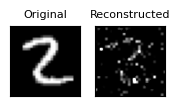

Reconstruction MSE = 0.092, Val loss on reconstructed = 0.886, Val acc on reconstructed = 71.61%
For m = 200 and alpha = 0.2:


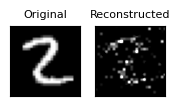

Reconstruction MSE = 0.093, Val loss on reconstructed = 1.015, Val acc on reconstructed = 67.91%
For m = 200 and alpha = 0.5:


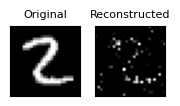

Reconstruction MSE = 0.095, Val loss on reconstructed = 1.103, Val acc on reconstructed = 65.94%
For m = 200 and alpha = 1:


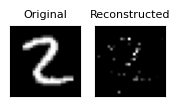

Reconstruction MSE = 0.100, Val loss on reconstructed = 1.427, Val acc on reconstructed = 53.35%
For m = 300 and alpha = 0.1:


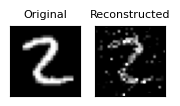

Reconstruction MSE = 0.051, Val loss on reconstructed = 0.171, Val acc on reconstructed = 94.81%
For m = 300 and alpha = 0.2:


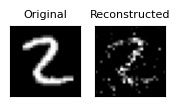

Reconstruction MSE = 0.061, Val loss on reconstructed = 0.267, Val acc on reconstructed = 92.50%
For m = 300 and alpha = 0.5:


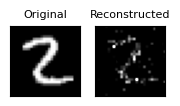

Reconstruction MSE = 0.080, Val loss on reconstructed = 0.550, Val acc on reconstructed = 86.11%
For m = 300 and alpha = 1:


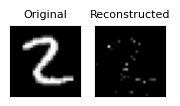

Reconstruction MSE = 0.097, Val loss on reconstructed = 1.574, Val acc on reconstructed = 51.61%
For m = 400 and alpha = 0.1:


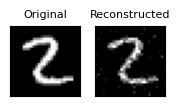

Reconstruction MSE = 0.026, Val loss on reconstructed = 0.075, Val acc on reconstructed = 97.86%
For m = 400 and alpha = 0.2:


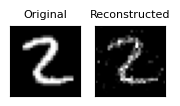

Reconstruction MSE = 0.035, Val loss on reconstructed = 0.122, Val acc on reconstructed = 96.68%
For m = 400 and alpha = 0.5:


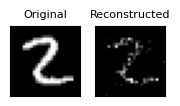

Reconstruction MSE = 0.067, Val loss on reconstructed = 0.398, Val acc on reconstructed = 90.08%
For m = 400 and alpha = 1:


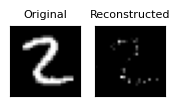

Reconstruction MSE = 0.096, Val loss on reconstructed = 1.305, Val acc on reconstructed = 65.63%
For m = 500 and alpha = 0.1:


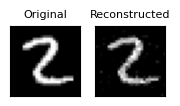

Reconstruction MSE = 0.011, Val loss on reconstructed = 0.056, Val acc on reconstructed = 98.42%
For m = 500 and alpha = 0.2:


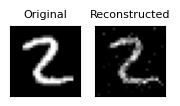

Reconstruction MSE = 0.024, Val loss on reconstructed = 0.081, Val acc on reconstructed = 97.95%
For m = 500 and alpha = 0.5:


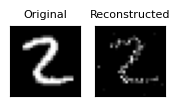

Reconstruction MSE = 0.059, Val loss on reconstructed = 0.279, Val acc on reconstructed = 94.22%
For m = 500 and alpha = 1:


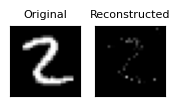

Reconstruction MSE = 0.097, Val loss on reconstructed = 1.404, Val acc on reconstructed = 62.94%
For m = 600 and alpha = 0.1:


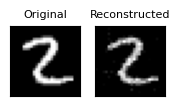

Reconstruction MSE = 0.006, Val loss on reconstructed = 0.049, Val acc on reconstructed = 98.60%
For m = 600 and alpha = 0.2:


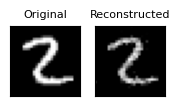

Reconstruction MSE = 0.018, Val loss on reconstructed = 0.065, Val acc on reconstructed = 98.32%
For m = 600 and alpha = 0.5:


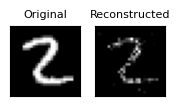

Reconstruction MSE = 0.058, Val loss on reconstructed = 0.236, Val acc on reconstructed = 95.79%
For m = 600 and alpha = 1:


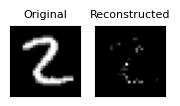

Reconstruction MSE = 0.098, Val loss on reconstructed = 1.369, Val acc on reconstructed = 66.36%


In [ ]:
# Perform grid search
# WARNING: This block takes 2hrs+ to run
for m in m_values:
    for a in alpha_values:
        print(f"For m = {m} and alpha = {a}:")

        # Generate random mxN Gaussian matrix with zero mean and unit variance
        A = np.random.normal(loc=0, scale=1, size=(m,N))

        # Compression
        Y = np.apply_along_axis(lambda x: A @ x.T, axis=1, arr=X)

        # Performing LASSO regression and reconstructing X
        lasso = Lasso(alpha=a).fit(A, Y.T)
        X_reconstructed = lasso.coef_

        MSE = mean_squared_error(X_reconstructed, X)
        visualise_pair(X[76,:], X_reconstructed[76,:])

        # Using the same random_state as before ensures that the labels are split the same way.
        # 80% val and 20% test
        X_rec_val, X_rec_test, labels_rec_val, labels_test = train_test_split(X_reconstructed,
                                                                              labels,
                                                                              test_size=0.2,
                                                                              random_state=42,
                                                                              stratify=labels)

        labels_rec_val_cat = to_categorical(labels_rec_val)

        # Validate model performance on reconstructed images to see how good our compression is
        val_X_hat_loss, val_X_hat_acc = model.evaluate(X_rec_val, labels_rec_val_cat, verbose=0)

        print(f"Reconstruction MSE = {MSE:.3f}, Val loss on reconstructed = {val_X_hat_loss:.3f}, Val acc on reconstructed = {100*val_X_hat_acc:.2f}%")

We see that a higher value of m leads to a smaller loss and a higher accuracy. However, the higher the value of m the smaller the compression of the images. We also notice that when alpha (lambda) = 0.1, better results are achieved no matter the value of m.

As such, we will consider m = 300 and lambda = 0.1 as the optimal values. Compressing the images using these parameters, the model achieves a low validation loss (0.171) and a high validation accuracy (94.81%) on the reconstructed images. When compressed, the size of the data is reduced by 61.73%, because:

data_percentage_reduction = 1 - m/N = 1 - 300/784 = 61.73%

### Compressing and reconstructing using the best values of m and lambda

In [ ]:
m = 300
alpha = 0.1

A = np.random.normal(loc=0, scale=1, size=(m,N))
Y = np.apply_along_axis(lambda x: A @ x.T, axis=1, arr=X)
lasso = Lasso(alpha=alpha).fit(A, Y.T)
X_reconstructed = lasso.coef_

MSE = mean_squared_error(X_reconstructed, X)
print(MSE)

X_rec_val, X_rec_test, labels_rec_val, labels_test = train_test_split(X_reconstructed,
                                                                      labels,
                                                                      test_size=0.2,
                                                                      random_state=42,
                                                                      stratify=labels)
labels_rec_val_cat = to_categorical(labels_rec_val)
labels_test_cat = to_categorical(labels_test)

0.05237234420728442


### Now let's test our model on both the original and reconstructed images:

In [ ]:
test_loss, test_acc = model.evaluate(X_test, labels_test_cat, verbose=0)
print(f"Loss on original images = {test_loss:.3f}, Accuracy on original images = {100*test_acc:.2f}%")
test_rec_loss, test_rec_acc = model.evaluate(X_rec_test, labels_test_cat, verbose=0)
print(f"Loss on reconstructed images = {test_rec_loss:.3f}, Accuracy on reconstructed images = {100*test_rec_acc:.2f}%")

Loss on original images = 0.068, Accuracy on original images = 98.08%
Loss on reconstructed images = 0.192, Accuracy on reconstructed images = 93.62%


For the original image dataset:


<Axes: >

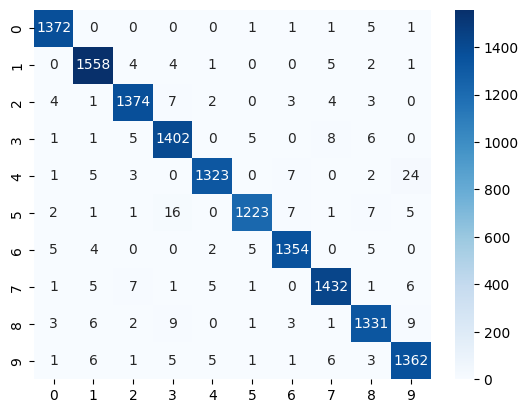

In [ ]:
print('For the original image dataset:')
labels_pred_original = np.apply_along_axis(np.argmax, axis=1, arr=model.predict(X_test, verbose=0))
CM_ori = confusion_matrix(y_true=labels_test, y_pred=labels_pred_original)
sns.heatmap(CM_ori, annot=True, fmt='d', cmap='Blues')

For the reconstructed image dataset:


<Axes: >

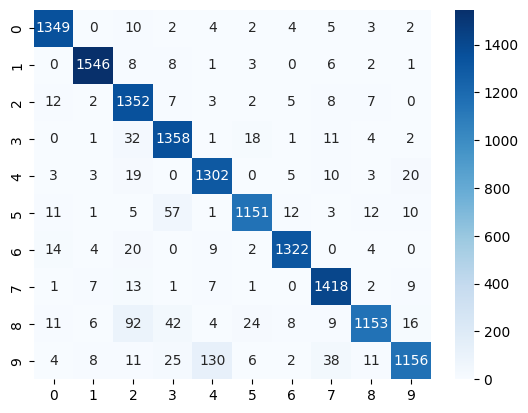

In [ ]:
print('For the reconstructed image dataset:')
labels_pred_reconstructed = np.apply_along_axis(np.argmax, axis=1, arr=model.predict(X_rec_test, verbose=0))
CM_rec = confusion_matrix(y_true=labels_test, y_pred=labels_pred_reconstructed)
sns.heatmap(CM_rec, annot=True, fmt='d', cmap='Blues')

Notes:

1. Using lower values of m or alpha leads to convergence issues in the LASSO optimization problem
2. Accuracy is a good measure of model performance in this problem because classes are balanced
